In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm
import os
from sklearn.metrics import f1_score
import json
import pandas as pd
from enum import Enum

Data generation

In [ ]:
class MatrixType(Enum):
    """
    Enum representing different available matrices in the data directory
    """
    SCALE_FREE = "Scale_Free_Laplacian"
    ERDOS_RENYI = "Erdos_Renyi_Laplacian"
    SMALL_WORLD = "Small_World_Laplacian"
    GRID_GRAPH = "Grid_Graph_Laplacian"
    BUS_33_MODIFIED = "33bus_modified_ybus_binary"
    WATER_NETWORK = "water_network"

In [112]:
def ensure_positive_definite(M, epsilon=1, min_threshold=1e-3):
    """
    Ensure M is well-conditioned ; add small value to diagonal if needed
    """
    min_eig = np.min(np.linalg.eigvals(M))
    
    if min_eig < min_threshold:
        print(f"Minimum eigenvalue too small ({min_eig:.2e}), adding {epsilon} to diagonal elements.")
        M += np.eye(M.shape[0]) * (abs(min_eig) + epsilon)
    
    return M

In [111]:
def load_B(matrix_type: MatrixType, data_dir='Data'):
    """
    Load a specific matrix from Data directory
    """
    matrix_name = matrix_type.value
    file_path = os.path.join(data_dir, matrix_name + '.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Matrix file '{matrix_name}' not found in {data_dir}.")

    B = pd.read_csv(file_path, header=None).values  # into a numpy array
    
    return ensure_positive_definite(B)

In [5]:
for matrix_type in MatrixType:
    B = load_B(matrix_type)
    print(f'Is {matrix_type.value} symmetric: {la.issymmetric(B)}')

Is Scale_Free_Laplacian symmetric: True
Is Erdos_Renyi_Laplacian symmetric: True
Is Small_World_Laplacian symmetric: True
Is Grid_Graph_Laplacian symmetric: True
Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.
Is 33bus_modified_ybus_binary symmetric: True
Is water_network symmetric: True


In [113]:
def generate_sparse_covariance(B, sample_scaling=1.0):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """

    n = len(B)

    # Mask diagonal of B matrix
    B_no_diag = B.copy()
    np.fill_diagonal(B_no_diag, 0)

    # Now count the number of non-zero elements per row (true degree)
    d = np.max(np.sum(B_no_diag != 0, axis=1))
    print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return S, N

Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.
Max degree in B 3
Number of samples 31
F1 norm 1.2931434073686014


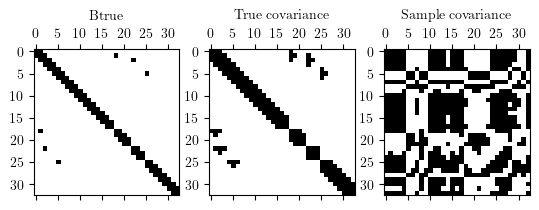

In [114]:
B = load_B(MatrixType.BUS_33_MODIFIED)
S, N = generate_sparse_covariance(B, sample_scaling=1)
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
plt.spy(B@B)
plt.title("True covariance")
plt.subplot(1,3,3)
plt.spy(np.linalg.inv(S)>0.1)
plt.title("Sample covariance")
print("Number of samples", N)
print("F1 norm", np.linalg.norm(np.linalg.inv(B@B)-S, ord="fro"))

Algorithm

In [9]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        if k % 5 == 0:  # Print every 5 iterations
            print(f"Iteration {k}, Error: {err:.2e}")
        
        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return X

In [10]:
def soft_thresholding_offdiag(B_new, Lambda, lambda_, rho):
    """
    Applies off-diagonal soft-thresholding.
    """
    
    # Compute argument for soft-thresholding
    X = rho * B_new + Lambda
    
    # Create a copy to modify
    Z_new = X.copy()
    
    # Off-diagonal mask
    mask_offdiag = ~np.eye(X.shape[0], dtype=bool)

    # Apply soft-thresholding only to off-diagonal elements
    Z_new[mask_offdiag] = np.sign(X[mask_offdiag]) * np.maximum(np.abs(X[mask_offdiag]) - lambda_, 0)

    return Z_new


In [11]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        # Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = soft_thresholding_offdiag(B_new, Lambda, lambda_, rho)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # print(f"ADMM update loss: ", np.linalg.norm(B_new - B, ord='fro') )
        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"ADMM Converged after {k+1} iterations.")
            break
        elif k == max_iter-1 :
            print(f"ADMM failed to converge after {k+1} iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [12]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

Simple experiment

In [13]:
B = load_B(matrix_type=MatrixType.BUS_33_MODIFIED)

Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.


In [ ]:
S, N = generate_sparse_covariance(B, sample_scaling=2)

print(f'Number of samples used: {N}')
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.1  # Regularization strength
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-5  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 3
Number of samples used: 62
Iteration 0, Error: 6.95e-01
Iteration 5, Error: 2.74e-12
Iteration 0, Error: 4.82e-01
Iteration 5, Error: 2.17e-14
Iteration 0, Error: 2.83e-01
Iteration 5, Error: 9.85e-16
Iteration 0, Error: 2.11e-01
Iteration 5, Error: 6.27e-16
Iteration 0, Error: 1.64e-01
Iteration 0, Error: 1.31e-01
Iteration 0, Error: 1.11e-01
Iteration 0, Error: 9.48e-02
Iteration 0, Error: 8.29e-02
Iteration 0, Error: 7.29e-02
Iteration 0, Error: 6.47e-02
Iteration 0, Error: 5.81e-02
Iteration 0, Error: 5.24e-02
Iteration 0, Error: 4.74e-02
Iteration 0, Error: 4.31e-02
Iteration 0, Error: 3.94e-02
Iteration 0, Error: 3.61e-02
Iteration 0, Error: 3.32e-02
Iteration 0, Error: 3.06e-02
Iteration 0, Error: 2.85e-02
Iteration 0, Error: 2.66e-02
Iteration 0, Error: 2.49e-02
Iteration 0, Error: 2.34e-02
Iteration 0, Error: 2.20e-02
Iteration 0, Error: 2.08e-02
Iteration 0, Error: 1.98e-02
Iteration 0, Error: 1.88e-02
Iteration 0, Error: 1.80e-02
Iteration 0, Error: 1.71e-0

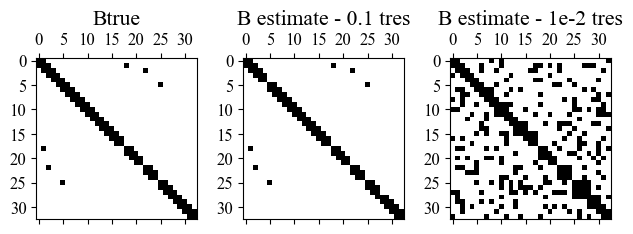

In [805]:
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.4))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")
plt.show()

Experimentation

In [806]:
def evaluate_f1_vs_lambda(
        lambda_values, B, sample_scaling=1.0,
        rho=1.0, max_iter=100, tol=1e-4,
        threshold=1e-4, save_plots = False, log_dir="experiment_logs"):
    """
    Evaluate f1 scores, 
    excluding diagonal elements, for each lambda.
    """
    
    B = np.array(B)
    n = B.shape[0]
    
    # Generate sample covariance S and sample size N
    S, N = generate_sparse_covariance(B, sample_scaling=sample_scaling)

    print("Number of samples:", N)
    print("Minimum eigenvalue of B:", np.min(np.linalg.eigvals(B)))

    # Ground-truth adjacency (full)
    ground_truth_adjacency = (B != 0).astype(int)

    # Exclude diagonals via a mask
    mask_offdiag = ~np.eye(n, dtype=bool)

    metrics = {
        "lambda": [],
        "f1": [],
    }

    for lambda_ in lambda_values:
        # Estimate precision matrix with user-defined ADMM function
        B_est = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

        # Threshold the estimate
        B_est_thresholded = hard_threshold(B_est, threshold)

        if save_plots:
            # Plot and save the sparsity patterns (optional, can remove if not needed)
            plt.figure(figsize=(6, 12))
            
            plt.subplot(1, 2, 1)
            plt.spy(B)
            plt.title("B (True)", fontsize=16)

            plt.subplot(1, 2, 2)
            plt.spy(B_est_thresholded)
            plt.title("B_est (Estimated)", fontsize=16)

            plot_path = os.path.join(log_dir, f"sparsity_lambda_{lambda_:.3f}.png")
            plt.savefig(plot_path)
            plt.close()
            
        
        predicted_adjacency = (B_est_thresholded != 0).astype(int)
        gt_offdiag = ground_truth_adjacency[mask_offdiag]
        pred_offdiag = predicted_adjacency[mask_offdiag]

        f1 = f1_score(gt_offdiag, pred_offdiag)

        # Store the results
        metrics["lambda"].append(lambda_)
        metrics["f1"].append(f1)

    return metrics

In [807]:
# Updated main loop
sample_scaling = 3
matrix_type = MatrixType.BUS_33_MODIFIED
B = load_B(matrix_type)
print(f'Is B pd: {np.min(np.linalg.eigvals(B))>0}')

log_dir = f"experiment_logs/{matrix_type._value_}/{sample_scaling}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0,0.5, 10).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 1.0,
    "max_iter": 200,
    "tol": 1e-4,
    "threshold": 1e-1,
    "log_dir": log_dir, 
    "save_plots": True
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_f1_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["f1"].idxmax()
best_f1 = metrics_df["f1"].max()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best f1 scores = {best_f1}")
print(f"Best lambda by f1 = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
plt.plot(metrics_df["lambda"], metrics_df["f1"])

plt.xlabel("Lambda")
plt.ylabel("F1 score")
plt.title("Metrics vs. F1")
plt.legend()
plot_path = os.path.join(log_dir, "f1_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.
Is B pd: True
Evaluating metrics for {'lambda_values': [0.0, 0.05555555555555555, 0.1111111111111111, 0.16666666666666666, 0.2222222222222222, 0.2777777777777778, 0.3333333333333333, 0.38888888888888884, 0.4444444444444444, 0.5], 'B': [[3.216010002689076, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 3.216010002689076, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 3.216010002689076, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 3.216010002689076, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best f1 scores = 0.9921259842519685
Best lambda by f1 = 0.278


F1 vs scaling 

In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})


In [ ]:
def plot_f1_vs_sample_scaling(
    best_lambda=0.278,
    rho=1.0,
    max_iter=200,
    tol=1e-4,
    threshold=1e-1,
    scaling_values=[0.1, 0.5, 1, 1.5, 2, 4, 5, 10, 20],
    num_trials=20,
    log_dir="experiment_scale_logs"
):
    """
    Plot F1 score and worst-case error vs. sample scaling for different graph types
    """

    os.makedirs(log_dir, exist_ok=True)

    # Figsize fits IEEE double column
    fig, axs = plt.subplots(2, 1, figsize=(3.5, 6), sharex=False)

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
    })

    markers = {
        MatrixType.BUS_33_MODIFIED: "o",
        MatrixType.WATER_NETWORK: "^",
        MatrixType.GRID_GRAPH: "o",
        MatrixType.SMALL_WORLD: "s",
        MatrixType.SCALE_FREE: "D",
        MatrixType.ERDOS_RENYI: "^"
    }
    linestyles = {
        MatrixType.BUS_33_MODIFIED: "dashed",
        MatrixType.WATER_NETWORK: "dashdot",
        MatrixType.GRID_GRAPH: "dashed",
        MatrixType.SMALL_WORLD: "dashdot",
        MatrixType.SCALE_FREE: "dotted",
        MatrixType.ERDOS_RENYI: (0, (3, 1, 1, 1))
    }

    legend_labels = {
    MatrixType.SCALE_FREE: "Scale Free",
    MatrixType.ERDOS_RENYI: "Erdős-Rényi",
    MatrixType.SMALL_WORLD: "Small World",
    MatrixType.GRID_GRAPH: "Grid Graph",
    MatrixType.BUS_33_MODIFIED: "IEEE Power Network",
    MatrixType.WATER_NETWORK: "Water Network",
    }

    # Use any of the following lines according to the usecase : top for synthetic and bottom for real-world
    # for matrix_type in [MatrixType.ERDOS_RENYI, MatrixType.GRID_GRAPH, MatrixType.SMALL_WORLD, MatrixType.SCALE_FREE]:
    for matrix_type in [MatrixType.BUS_33_MODIFIED, MatrixType.WATER_NETWORK]:
            f1_means = [] # F1 scores averaged over num_trials experiments keeping parameters constant
            err_means = [] # Worst case off diag errors errors averaged over num_trials experiments keeping parameters constant
            err_stds = [] # Standard deviations for plotting box errors 

            B = load_B(matrix_type)
            ground_truth_adjacency = (B != 0).astype(int) # Ground truth for F1 metric
            mask_offdiag = ~np.eye(len(B), dtype=bool) # To ignore diagonals

            for scale in scaling_values:
                f1_trials = []
                error_trials = []

                for _ in range(num_trials):
                    S, N = generate_sparse_covariance(B, sample_scaling=scale)
                    B_est = admm_precision_matrix(S, best_lambda, rho, max_iter, tol)
                    B_est_thresholded = hard_threshold(B_est, threshold)

                    pred_adj = (B_est_thresholded != 0).astype(int)

                    f1 = f1_score(ground_truth_adjacency[mask_offdiag], pred_adj[mask_offdiag])
                    max_error = np.max(np.abs(B_est - B)[mask_offdiag])

                    f1_trials.append(f1)
                    error_trials.append(max_error)

                f1_means.append(np.mean(f1_trials))
                err_means.append(np.mean(error_trials))
                err_stds.append(np.std(error_trials))

                print(f"{matrix_type.name}, scale={scale}, N={N}, F1={np.mean(f1_trials):.3f}, MaxErrStd={np.std(error_trials):.3f}")

            label = legend_labels[matrix_type]
            marker = markers[matrix_type]
            linestyle = linestyles[matrix_type]

            # Plot F1 without error bars
            axs[0].plot(
                scaling_values, f1_means,
                label=label,
                marker=marker,
                linestyle=linestyle,
                linewidth=2,
                markersize=4
            )

            # Plot max error with error bars
            axs[1].errorbar(
                scaling_values,
                err_means,
                yerr=err_stds,
                label=label,
                marker=marker,
                linestyle=linestyle,
                linewidth=2,
                capsize=4,
                elinewidth=1,
                capthick=1,
                markersize=4
            )

    for ax in axs:
        ax.set_xlabel(r"$\tau = N/(d^2 \log p)$", fontsize=13)
        ax.legend(fontsize=9)
        ax.grid(True)

    axs[0].set_ylabel("Average F-score", fontsize=13)
    axs[1].set_ylabel(r"$\|\widehat{L} - L^*\|_{\infty}$", fontsize=13)

    plt.tight_layout()
    plt.savefig("synthetic_data_scaling_highres.png", dpi=600)
    plt.show()


Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.
Max degree in B 3
Iteration 0, Error: 6.58e-01
Iteration 5, Error: 4.65e-16
Iteration 0, Error: 4.53e-01
Iteration 5, Error: 3.30e-14
Iteration 0, Error: 1.78e-01
Iteration 5, Error: 7.30e-16
Iteration 0, Error: 2.67e-01
Iteration 5, Error: 1.33e-15
Iteration 0, Error: 3.17e-01
Iteration 5, Error: 9.88e-16
Iteration 0, Error: 2.35e-01
Iteration 5, Error: 7.83e-16
Iteration 0, Error: 1.52e-01
Iteration 0, Error: 1.07e-01
Iteration 0, Error: 8.74e-02
Iteration 0, Error: 7.32e-02
Iteration 0, Error: 6.18e-02
Iteration 0, Error: 5.31e-02
Iteration 0, Error: 4.62e-02
Iteration 0, Error: 4.06e-02
Iteration 0, Error: 3.63e-02
Iteration 0, Error: 3.31e-02
Iteration 0, Error: 3.08e-02
Iteration 0, Error: 2.86e-02
Iteration 0, Error: 2.66e-02
Iteration 0, Error: 2.47e-02
Iteration 0, Error: 2.32e-02
Iteration 0, Error: 2.18e-02
Iteration 0, Error: 2.05e-02
Iteration 0, Error: 1.93e-02
Iteration 0, Error: 1.82e-02
Iteration 

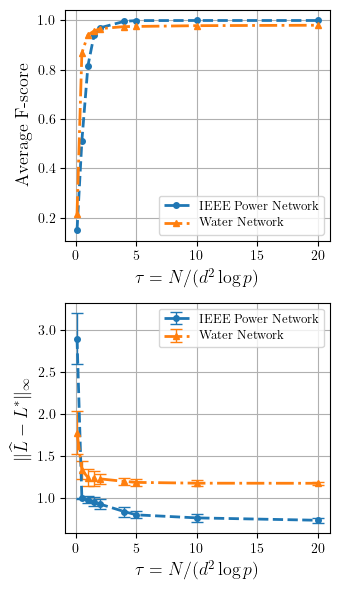

In [110]:
plot_f1_vs_sample_scaling()

Real world estimates
















In [64]:
B_bus = load_B(MatrixType.BUS_33_MODIFIED)
S_bus, _ = generate_sparse_covariance(B_bus, sample_scaling=4)
B_water = load_B(MatrixType.WATER_NETWORK)
S_water, _ = generate_sparse_covariance(B_water, sample_scaling=4)

lambda_ = 0.1  # Regularization strength
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-5  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate_bus = admm_precision_matrix(S_bus, 0.278, rho, max_iter, tol)
B_estimate_water = admm_precision_matrix(S_water, 0.175, rho, max_iter, tol)


Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.
Max degree in B 3
Max degree in B 5
Iteration 0, Error: 5.16e-01
Iteration 5, Error: 5.89e-16
Iteration 0, Error: 3.88e-01
Iteration 5, Error: 7.77e-16
Iteration 0, Error: 1.95e-01
Iteration 5, Error: 8.74e-16
Iteration 0, Error: 2.36e-01
Iteration 0, Error: 1.66e-01
Iteration 0, Error: 1.08e-01
Iteration 0, Error: 7.14e-02
Iteration 0, Error: 4.93e-02
Iteration 0, Error: 3.53e-02
Iteration 0, Error: 2.59e-02
Iteration 0, Error: 1.94e-02
Iteration 0, Error: 1.48e-02
Iteration 0, Error: 1.14e-02
Iteration 0, Error: 8.78e-03
Iteration 0, Error: 6.65e-03
Iteration 0, Error: 5.07e-03
Iteration 0, Error: 3.89e-03
Iteration 0, Error: 3.00e-03
Iteration 0, Error: 2.35e-03
Iteration 0, Error: 1.87e-03
Iteration 0, Error: 1.48e-03
Iteration 0, Error: 1.18e-03
Iteration 0, Error: 9.35e-04
Iteration 0, Error: 7.44e-04
Iteration 0, Error: 5.92e-04
Iteration 0, Error: 4.72e-04
Iteration 0, Error: 3.76e-04
Iteration 0, Error: 3

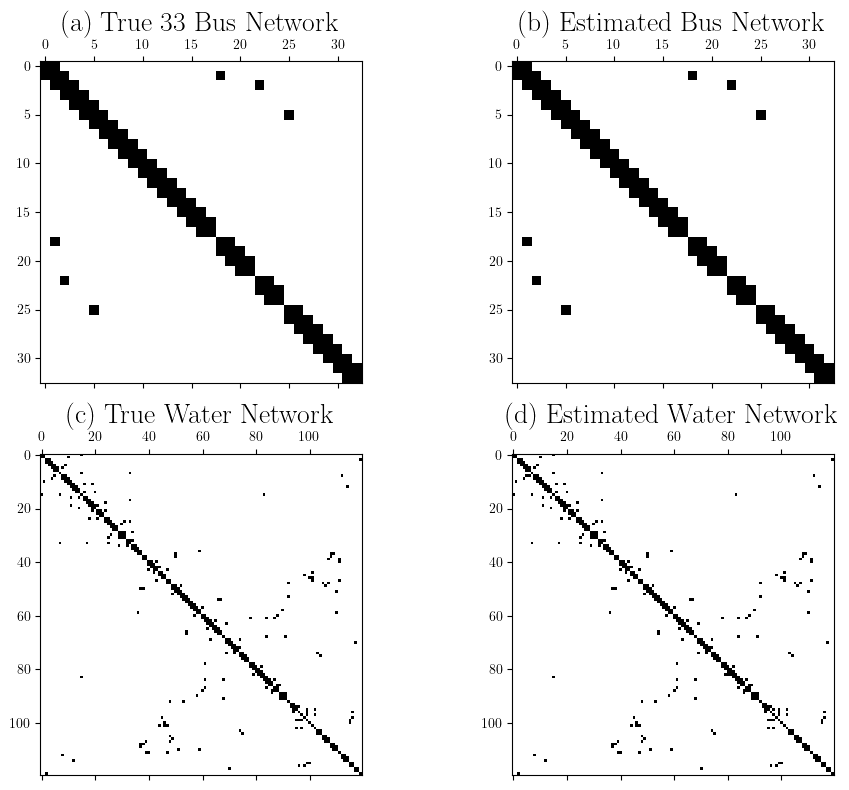

In [ ]:
import matplotlib.pyplot as plt

font_size = 20
# Create a new figure
plt.figure(figsize=(10, 8))

# Subplot 1: True B_bus
plt.subplot(2, 2, 1)
plt.spy(B_bus)
plt.title('(a) True 33 Bus Network', fontsize=font_size)

# Subplot 2: Estimated B_bus after thresholding
plt.subplot(2, 2, 2)
plt.spy(hard_threshold(B_estimate_bus, 0.1))
plt.title('(b) Estimated Bus Network', fontsize=font_size)

# Subplot 3: True B_water
plt.subplot(2, 2, 3)
plt.spy(B_water)
plt.title('(c) True Water Network', fontsize=font_size)

# Subplot 4: Estimated B_water after thresholding
plt.subplot(2, 2, 4)
plt.spy(hard_threshold(B_estimate_water, 0.1))
plt.title('(d) Estimated Water Network', fontsize=font_size)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


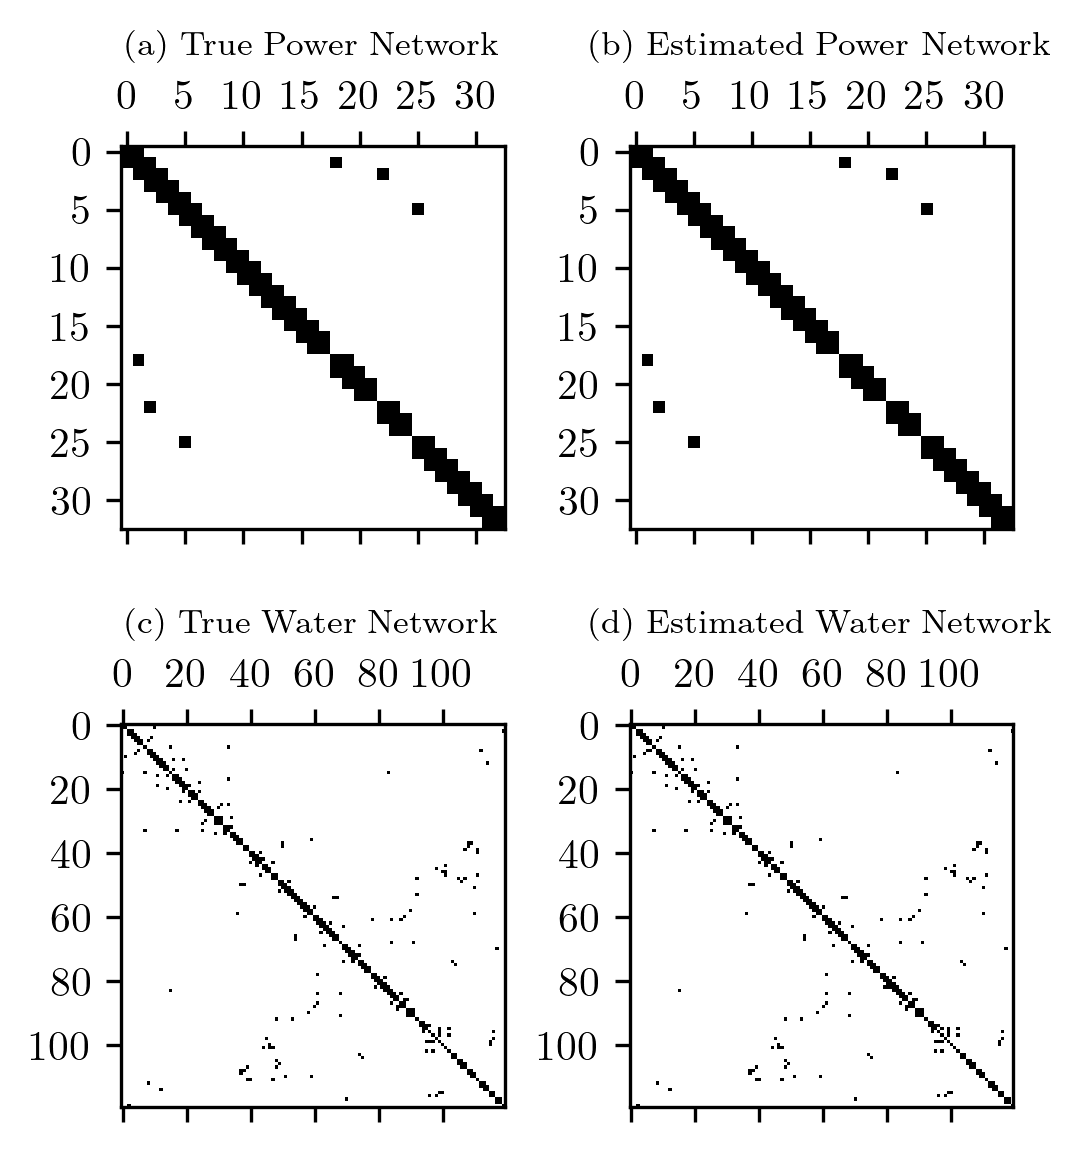

In [83]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(3.5, 4), dpi=300)

# Font size for subplot titles
title_fontsize = 8  # small but readable in IEEE column
title_pad = 6       # slight spacing above subplot title

axs[0, 0].spy(B_bus)
axs[0, 0].set_title('(a) True Power Network ', fontsize=title_fontsize, pad=title_pad)

axs[0, 1].spy(hard_threshold(B_estimate_bus, 0.1))
axs[0, 1].set_title('(b) Estimated Power Network', fontsize=title_fontsize, pad=title_pad)

axs[1, 0].spy(B_water)
axs[1, 0].set_title('(c) True Water Network', fontsize=title_fontsize, pad=title_pad)

axs[1, 1].spy(hard_threshold(B_estimate_water, 0.1))
axs[1, 1].set_title('(d) Estimated Water Network', fontsize=title_fontsize, pad=title_pad)

# Reduce space between subplots
plt.tight_layout(pad=0.8)  # Adjust if you want even tighter layout

# Save as high-res image for IEEE paper
plt.savefig("ieee_column_subplots.pdf", bbox_inches='tight')  # or use .png/.eps
plt.show()
